# Project : Hypothyroid Classification

**We have been provided the File and Objectives are :**

- Prepare the dataset for analysis, using methods learnt and researched independently, including but not limited to Missing Value Imputation, Outlier Detection etc, that have been covered in course yet. Find out your observations on different variables using descriptive statistics, Visualization etc. Report if there is any pattern present in the data.
- Apply a Classification algorithm using ‘binaryClass’ column as target variable. Compare all models using various performance metrics.
- Provide all inferences of your findings.

---

## Solution

### Introduction

This project focuses on the analysis and classification of thyroid disease using patient medical data from the Garavan Institute. The dataset contains clinical and laboratory features, including hormone levels and patient history, with the goal of predicting whether a patient has hypothyroidism. The process involves data cleaning, handling missing values, exploratory data analysis (EDA), and applying various machine learning classification algorithms. By using the binaryClass column as the target variable, the study aims to evaluate model performance and identify patterns that can support early and accurate diagnosis of thyroid conditions.

---

### Basic Information of File(hypothyroid_classification) :

The dataset contains 3772 instances with 30 columns, all currently of type object. A quick look reveals:

- Some values like ‘?’ indicate missing data.
- Numerical fields like age, TSH, T3, TT4, T4U, FTI, etc., are stored as strings and must be converted.
- The target variable is binaryClass, with classes like ‘P’ (positive) and ‘N’ (negative).

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn preprocessing and modeling
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
)
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# Evaluation metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)

# Display settings
pd.set_option('display.max_columns', None)

### Importing Required Libraries

To initiate the analysis, we import all essential libraries required for data loading, visualization, preprocessing, modeling, and evaluation.

- **NumPy & Pandas**: For numerical operations and dataframe handling.
- **Matplotlib & Seaborn**: For plotting and data visualization.
- **Scikit-learn Modules**:
  - **Preprocessing tools**: Scaling, encoding, imputation.
  - **Model selection**: Data splitting and cross-validation.
  - **Classifiers**: Logistic Regression, Decision Tree, Random Forest, SVM, KNN, Naive Bayes, and ensemble methods like AdaBoost, Bagging, Gradient Boosting.
  - **Metrics**: Accuracy, precision, recall, F1 score, confusion matrix, ROC-AUC and others.
- **XGBoost**: For implementing one of the most powerful gradient boosting classifiers.

The inclusion of advanced ensemble classifiers and pipelines prepares us for exploring a variety of models and preprocessing strategies. These will enable comprehensive training, evaluation, and comparison — all aligned with our project’s goal of end-to-end classification model development and analysis.


In [2]:
# Loading the dataset and check initial structure

df = pd.read_csv("hypothyroid_classification.csv")

print("Dataset Shape:", df.shape)
print(df.head())
display(df.info())
df.count()
df.describe().transpose()

Dataset Shape: (3772, 30)
  age sex on thyroxine query on thyroxine on antithyroid medication sick  \
0  41   F            f                  f                         f    f   
1  23   F            f                  f                         f    f   
2  46   M            f                  f                         f    f   
3  70   F            t                  f                         f    f   
4  70   F            f                  f                         f    f   

  pregnant thyroid surgery I131 treatment query hypothyroid  \
0        f               f              f                 f   
1        f               f              f                 f   
2        f               f              f                 f   
3        f               f              f                 f   
4        f               f              f                 f   

  query hyperthyroid lithium goitre tumor hypopituitary psych TSH measured  \
0                  f       f      f     f             f     

None

count unique    top  freq
age                        3772     94     59    95
sex                        3772      3      F  2480
on thyroxine               3772      2      f  3308
query on thyroxine         3772      2      f  3722
on antithyroid medication  3772      2      f  3729
sick                       3772      2      f  3625
pregnant                   3772      2      f  3719
thyroid surgery            3772      2      f  3719
I131 treatment             3772      2      f  3713
query hypothyroid          3772      2      f  3538
query hyperthyroid         3772      2      f  3535
lithium                    3772      2      f  3754
goitre                     3772      2      f  3738
tumor                      3772      2      f  3676
hypopituitary              3772      2      f  3771
psych                      3772      2      f  3588
TSH measured               3772      2      t  3403
TSH                        3772    288      ?   369
T3 measured                3772      2      t  3003
T3                         3772     70      ?   769
TT4 measured               3772      2      t  3541
TT4                        3772    242      ?   231
T4U measured               3772      2      t  3385
T4U                        3772    147      ?   387
FTI measured               3772      2      t  3387
FTI                        3772    235      ?   385
TBG measured               3772      1      f  3772
TBG                        3772      1      ?  3772
referral source            3772      5  other  2201
binaryClass                3772      2      P  3481

### **Loading the dataset and examining the initial structure**

The dataset has been successfully loaded with a total of **3772 rows** and **30 columns**.

From the initial five rows, we observe the following:
- The dataset includes a mix of numerical and categorical attributes (e.g., `age`, `sex`, `on thyroxine`, `TSH`, `T3`, etc.).
- A significant number of attributes are **binary (t/f)** indicating boolean responses to medical conditions or test statuses.
- Multiple attributes represent lab results (like `TSH`, `T3`, `T4U`, `FTI`) and appear as numerical but are stored as object types, suggesting **presence of placeholders or non-numeric entries like '?'**.
- The `"referral source"` column contains values like `'other'`, which likely acts as a **catch-all category** and may be treated as missing or ambiguous during cleaning.

From the `info()` and `describe()` outputs:
- All 30 columns show **non-null entries**, but this is misleading since many fields contain `'?'`, which is not automatically treated as missing.
- **All columns are currently of object dtype**, including those that should be numeric such as `age`, `TSH`, and other lab test results. This confirms a **need for datatype correction and placeholder handling**.
- Descriptive statistics confirm irregular value distributions — for example, the `age` column has 94 unique values with a mode of 59.

**Additional Insight:**
- Columns like `"TBG"` and `"TBG measured"` show only one unique value each (`'?'` and `'f'` respectively), indicating no usable variation and can potentially be dropped.
- The `"binaryClass"` target column shows values `'P'` and `'N'`, where `'P'` seems to dominate (as inferred from the frequency count 3481 out of 3772).

**Observation:** <br>
- Despite no nulls, **missing or dirty data is likely hidden in object columns**, especially in numerical fields encoded as strings with `?`.
- The `"referral source"` column may also need to be assessed for reliability due to ambiguous `"other"` values.
- Some fields (like `"TBG"`) are **completely non-informative** and may be safely excluded.

**Conclusion:** <br>
This step gives a foundational view of the data structure and highlights the need for:
- **Cleaning invalid entries** like `'?'` and `'other'`
- **Proper data type conversion**
- **Dropping columns with no usable information**  
before any analysis or modeling steps can be performed.


---

## Step-1 : Data Cleaning
- To replace all '?' and 'other' entries with NaN
- Convert numeric columns to proper numeric types.
- TBG column is entirely missing and can be dropped.

In [3]:
# 1st Objective of Treating Missing Values
  
pd.set_option('future.no_silent_downcasting', True)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

# Replace '?' with NaN
df = df.replace('?', np.nan).infer_objects(copy=False)

# Replace 'other' in 'referral source' column with NaN 
if 'referral source' in df.columns:
    df['referral source'] = df['referral source'].replace('other', np.nan)

# Convert known numeric columns
numeric_cols = ['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI', 'TBG']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

print("\nMissing values before cleaning (in %):")
print((df.isna().sum() / len(df) * 100).sort_values(ascending=False).round(2))
# Dropping Coloumn
df.drop(columns=['TBG'], inplace=True)

categorical_cols = df.select_dtypes(include='object').columns.drop('binaryClass')
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Impute missing values
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])
print("\nRemaining missing values after cleaning:")
print(df.isna().sum().sort_values(ascending=False))

# Display cleaned Data
print("\nCleaned Data Preview:")
display(df.head(15))# shows the first 15 rows for Confirmation




Missing values before cleaning (in %):
TBG                         100.00
referral source              58.35
T3                           20.39
T4U                          10.26
FTI                          10.21
TSH                           9.78
TT4                           6.12
sex                           3.98
age                           0.03
pregnant                      0.00
on thyroxine                  0.00
query on thyroxine            0.00
on antithyroid medication     0.00
sick                          0.00
tumor                         0.00
goitre                        0.00
lithium                       0.00
query hyperthyroid            0.00
query hypothyroid             0.00
I131 treatment                0.00
thyroid surgery               0.00
hypopituitary                 0.00
TT4 measured                  0.00
T3 measured                   0.00
psych                         0.00
TSH measured                  0.00
FTI measured                  0.00
T4U measured   

age sex on thyroxine query on thyroxine on antithyroid medication sick  \
0  41.00   F            f                  f                         f    f   
1  23.00   F            f                  f                         f    f   
2  46.00   M            f                  f                         f    f   
3  70.00   F            t                  f                         f    f   
4  70.00   F            f                  f                         f    f   
5  18.00   F            t                  f                         f    f   
6  59.00   F            f                  f                         f    f   
7  80.00   F            f                  f                         f    f   
8  66.00   F            f                  f                         f    f   
9  68.00   M            f                  f                         f    f   
10 84.00   F            f                  f                         f    f   
11 67.00   F            t                  f                         f    f   
12 71.00   F            f                  f                         f    t   
13 59.00   F            f                  f                         f    f   
14 28.00   M            f                  f                         f    f   

   pregnant thyroid surgery I131 treatment query hypothyroid  \
0         f               f              f                 f   
1         f               f              f                 f   
2         f               f              f                 f   
3         f               f              f                 f   
4         f               f              f                 f   
5         f               f              f                 f   
6         f               f              f                 f   
7         f               f              f                 f   
8         f               f              f                 f   
9         f               f              f                 f   
10        f               f              f                 f   
11        f               f              f                 f   
12        f               f              f                 f   
13        f               f              f                 f   
14        f               f              f                 f   

   query hyperthyroid lithium goitre tumor hypopituitary psych TSH measured  \
0                   f       f      f     f             f     f            t   
1                   f       f      f     f             f     f            t   
2                   f       f      f     f             f     f            t   
3                   f       f      f     f             f     f            t   
4                   f       f      f     f             f     f            t   
5                   f       f      f     f             f     f            t   
6                   f       f      f     f             f     f            f   
7                   f       f      f     f             f     f            t   
8                   f       f      f     t             f     f            t   
9                   f       f      f     f             f     f            t   
10                  f       f      f     t             f     f            t   
11                  f       f      f     f             f     f            t   
12                  t       f      f     f             f     f            t   
13                  f       f      f     f             f     f            t   
14                  f       f      f     f             f     f            t   

    TSH T3 measured   T3 TT4 measured    TT4 T4U measured  T4U FTI measured  \
0  1.30           t 2.50            t 125.00            t 1.14            t   
1  4.10           t 2.00            t 102.00            f 0.98            f   
2  0.98           f 2.00            t 109.00            t 0.91            t   
3  0.16           t 1.90            t 175.00            f 0.98            f   
4  0.72           t 1.20            t  61.00           

## Treating Missing Values and Cleaning the Dataset

This step addresses the first major objective — **identifying and treating missing values**, which were previously hidden as special characters like `'?'` or ambiguous labels like `'other'`.

### Transformations Applied:
- All `'?'` values in the dataset were replaced with **`NaN`** to standardize missing data representation.
- The `"referral source"` column had the label `'other'`, which was treated as a vague category and hence **replaced with `NaN`**.
- Numeric features such as `age`, `TSH`, `T3`, `TT4`, `T4U`, `FTI`, and `TBG` were explicitly **converted to numeric types**, coercing non-numeric values into `NaN`.
- A missing-value percentage check was added **before cleaning**, revealing that:
  - `TBG` was entirely missing (**100%**),
  - `referral source` had **~58.35% missing**,
  - and other features like `T3`, `T4U`, and `FTI` had **10–20% missing**.
- The `TBG` column was **dropped** since it had no usable data and held limited analytical value.

### Missing Value Imputation Strategy:
- **Numerical columns** were imputed using the **median**, which is robust against outliers.
- **Categorical columns** were imputed using the **mode**, filling each column with its most frequently occurring value.

### Outcome:
- All missing values have been successfully treated, as confirmed by `df.isnull().sum()` which now shows **zero missing values** across all features.
- A cleaned preview of the first 15 rows confirms correct imputation and conversion.
- All features are now ready for scaling, visualization, and modeling steps.

This data cleaning forms a **solid foundation for downstream exploratory and predictive analysis**, ensuring the dataset is clean, consistent, and model-ready.

---

## Step-2 : Outlier Detection & Handling
- Detect outliers using the Interquartile Range method.
- Visualize them with boxplots.
- Handle them using capping method




age: 1 outliers capped
TSH: 424 outliers capped
T3: 456 outliers capped
TT4: 215 outliers capped
T4U: 205 outliers capped
FTI: 277 outliers capped


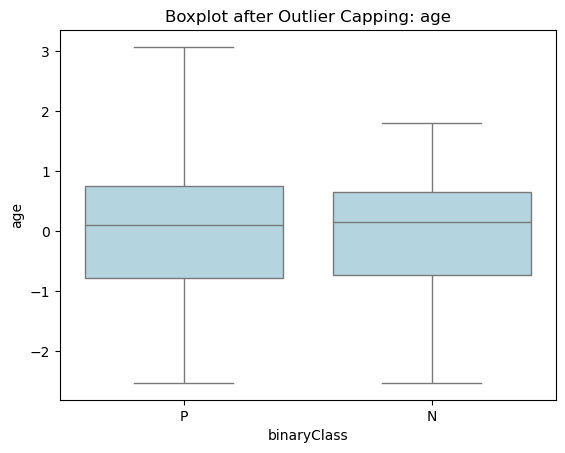

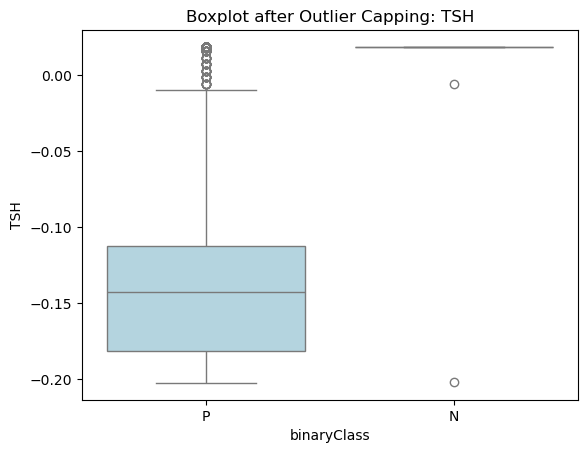

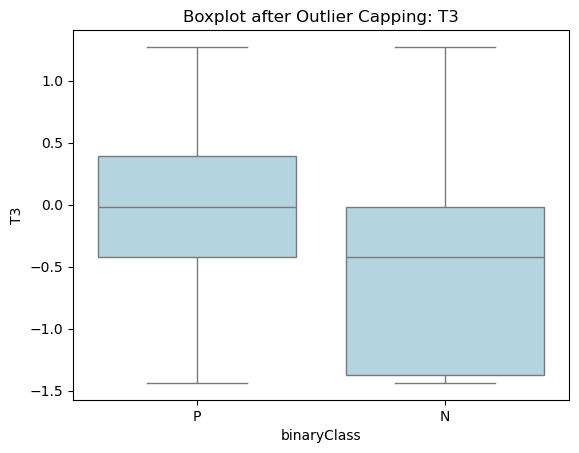

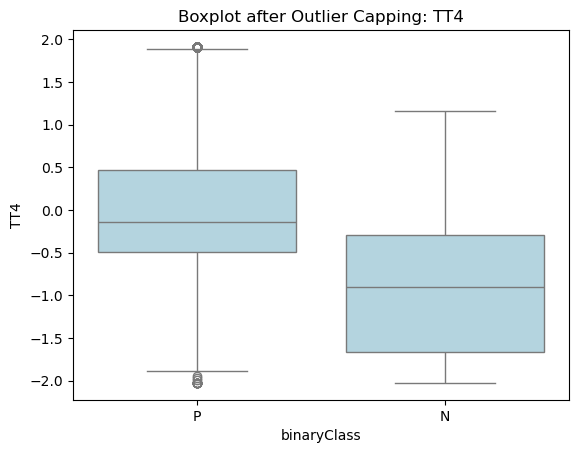

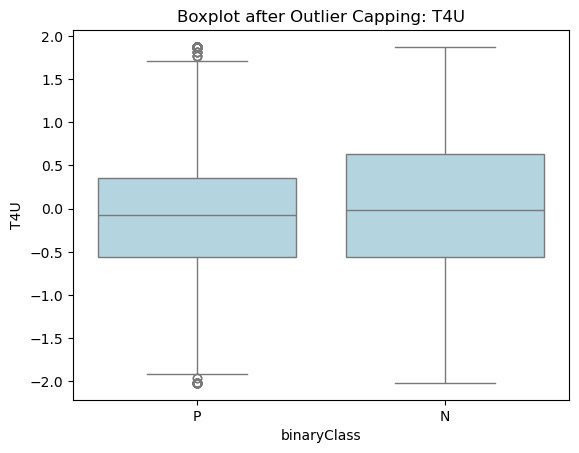

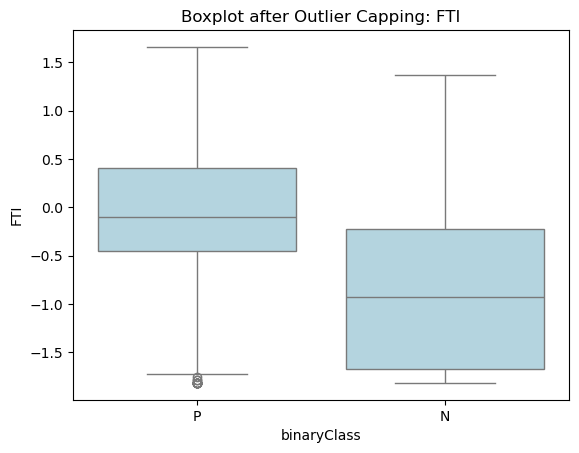

In [4]:
# Standard Scaling of Numeric Columns before Outlier Treatment
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Detecting Outliers and Treating Them using IQR Capping
def cap_outliers_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = ((df[col] < lower) | (df[col] > upper)).sum()
    print(f"{col}: {outliers} outliers capped")

    # Capping outliers
    df[col] = np.where(df[col] < lower, lower,
                np.where(df[col] > upper, upper, df[col]))

# Apply capping to each numerical column
for col in numerical_cols:
    cap_outliers_iqr(df, col)

# Boxplots after outlier capping
for col in numerical_cols:
    sns.boxplot(x='binaryClass', y=col, data=df, color='lightblue')
    plt.title(f"Boxplot after Outlier Capping: {col}")
    plt.show()


### **Standardizing and Treating Outliers in Numerical Features**

This step focuses on identifying and capping extreme values in the numerical columns to prevent them from distorting model training or skewing descriptive statistics. Before detecting outliers, we **standardized all numeric columns** to a common scale using **StandardScaler**, which ensures uniform sensitivity across features.

**Steps Performed:**
- **Standard Scaling** was applied to numeric columns like `age`, `TSH`, `T3`, `TT4`, `T4U`, and `FTI`. This transformation centers data around the mean (0) and scales it to unit variance, which improves the reliability of outlier detection.
- Outliers were detected using the **Interquartile Range (IQR) method**, where values falling below `Q1 - 1.5*IQR` or above `Q3 + 1.5*IQR` are flagged.
- Detected outliers were not removed but **capped** at the nearest valid IQR threshold to preserve data volume while minimizing their impact.

**Outlier Summary:**
- `T3` and `TSH` showed the **highest number of outliers** with 456 and 424 records capped respectively.
- Other features like `FTI`, `T4U`, and `TT4` also showed significant skewness, indicating strong variability in patient hormone levels.

**Visual Validation:**
- **Boxplots** were plotted for each numeric column (post-capping) against the `binaryClass` label. These show visibly reduced whisker lengths and cleaner box distributions after capping.
- Scaling ensures fair comparison of box distributions across classes (`P` vs `N`), highlighting subtle trends in hormone levels that differ across conditions.

This step ensures that **scaled and capped numeric features** are now ready for unbiased modeling and descriptive analysis without distortions from extreme values.

---

In [5]:
# Save the fully cleaned and preprocessed dataset
df.to_csv("hypothyroid_classification_cleaned.csv", index=False)
print("Cleaned dataset saved as 'hypothyroid_classification_cleaned.csv'")


Cleaned dataset saved as 'hypothyroid_classification_cleaned.csv'


## Step-3 : Exploratory Data Analysis (EDA)
### Goals :
- Value distributions
- Class imbalance
- Relationships between variables
- Patterns or anomalies



Class Distribution:


binaryClass
P    3481
N     291
Name: count, dtype: int64

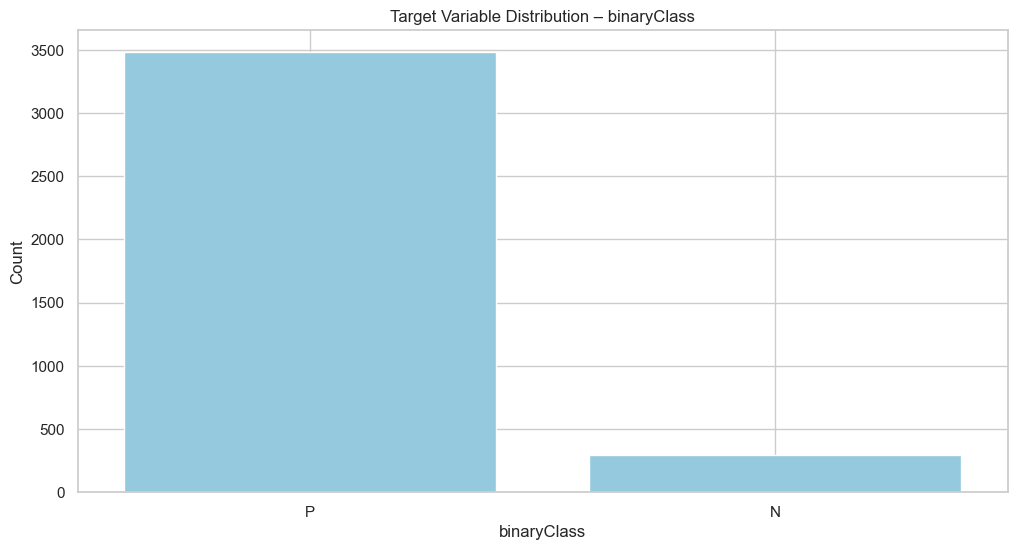

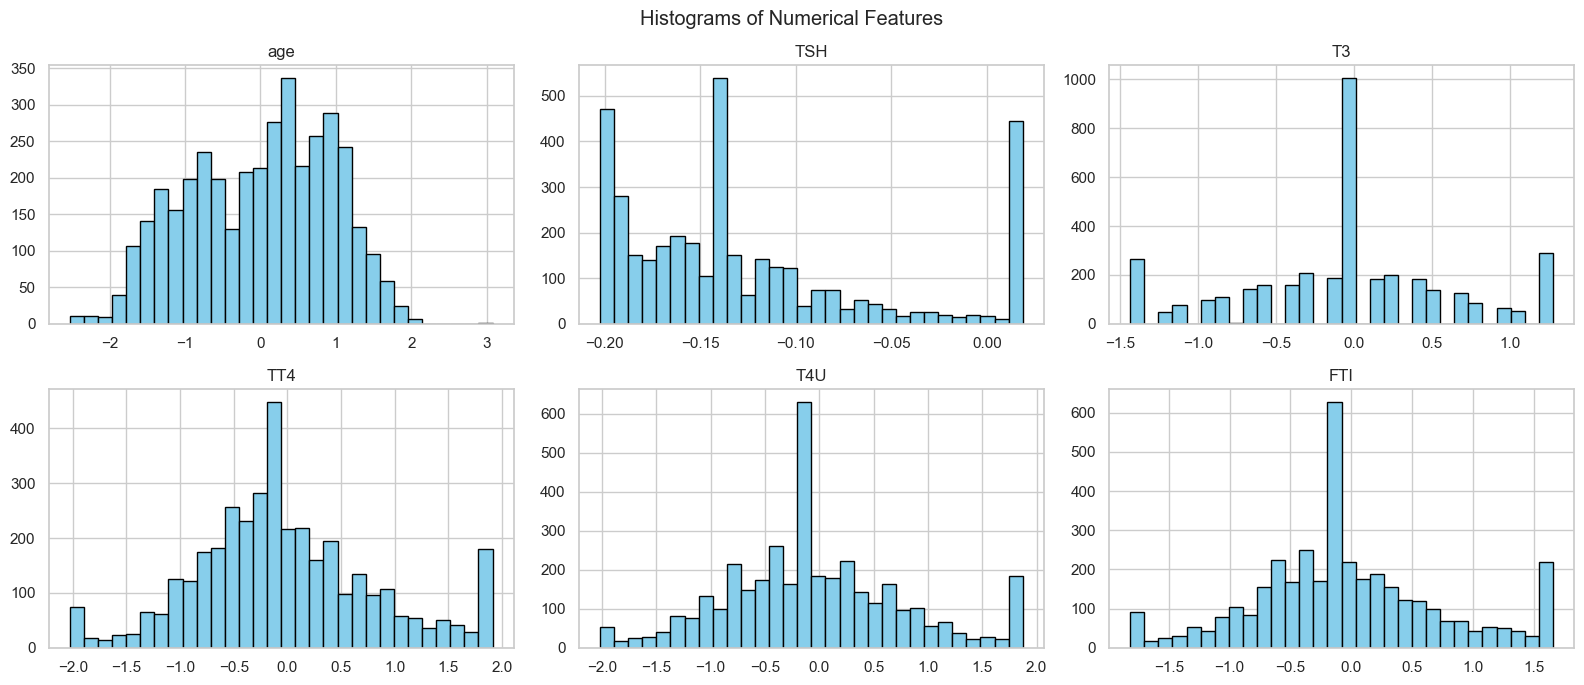

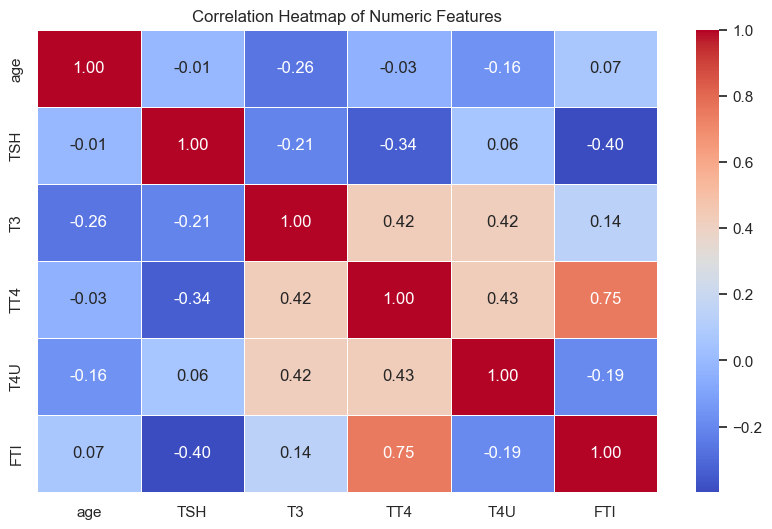

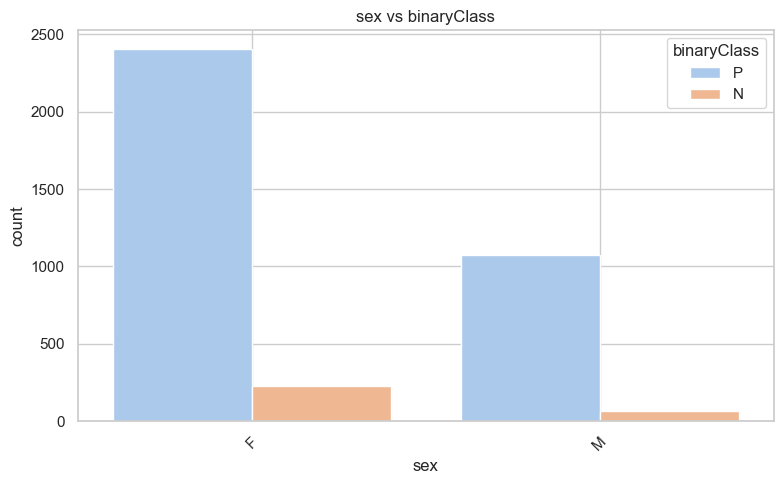

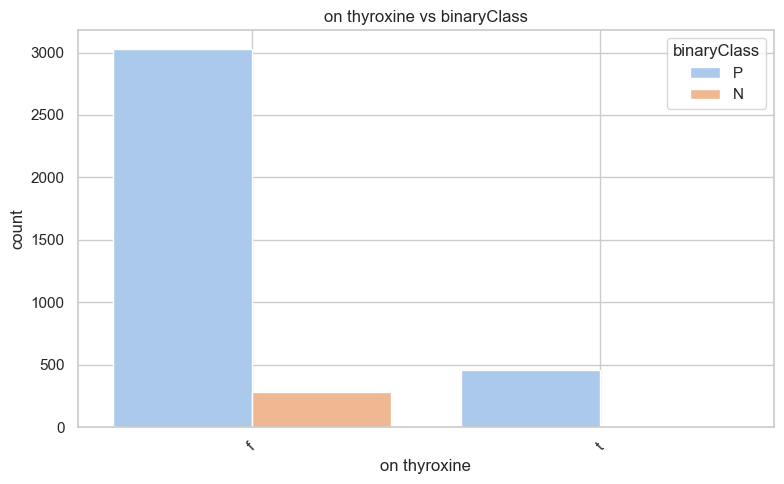

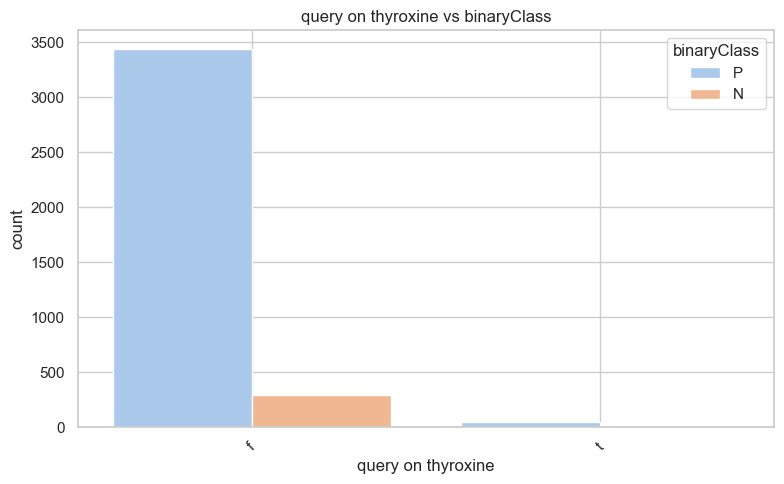

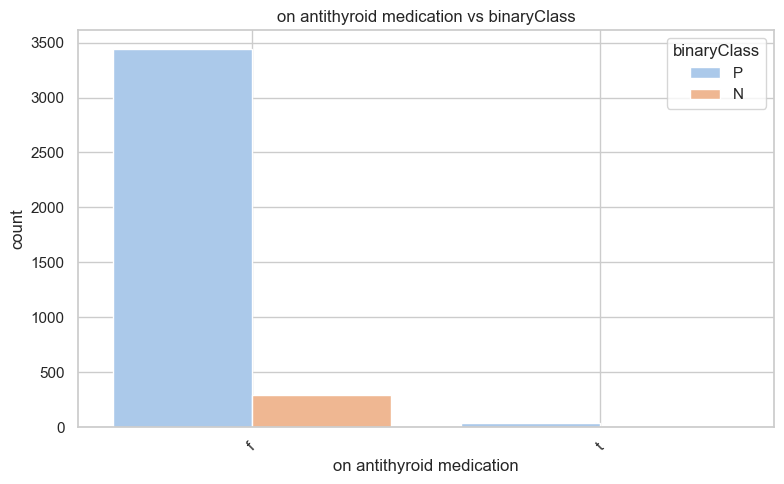

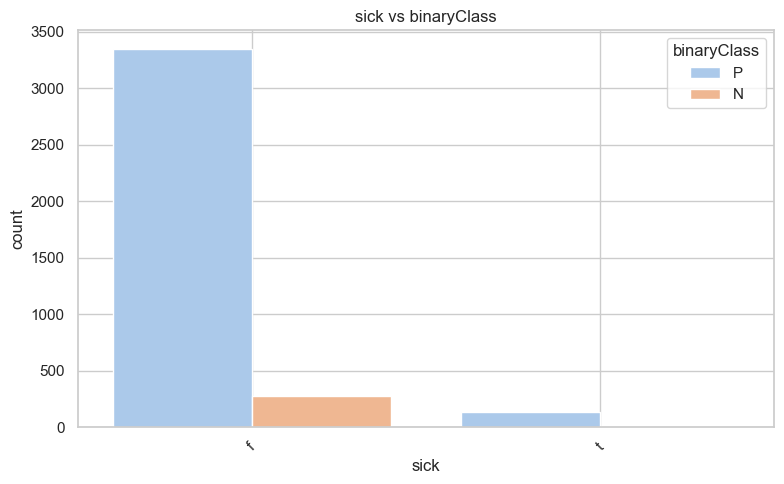

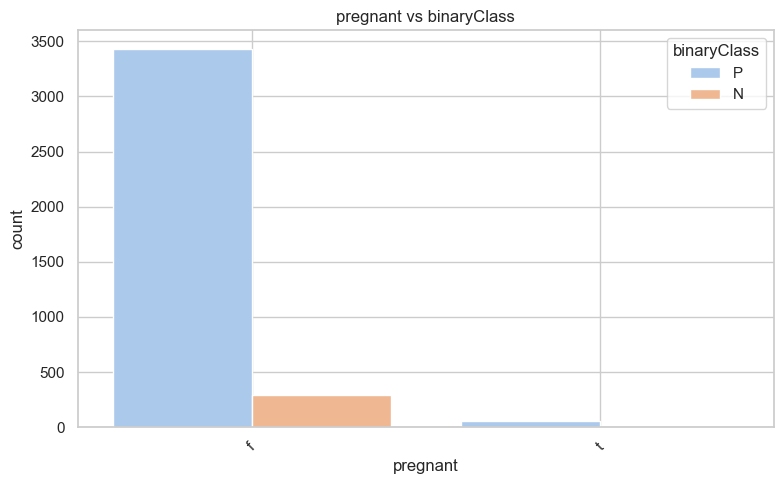

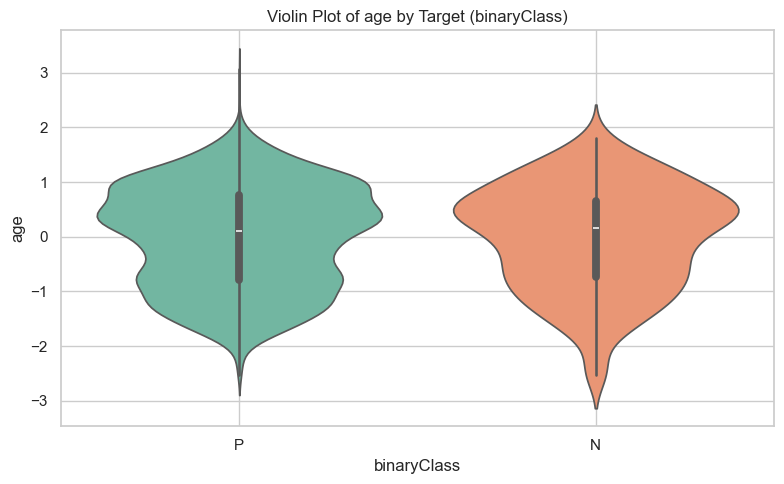

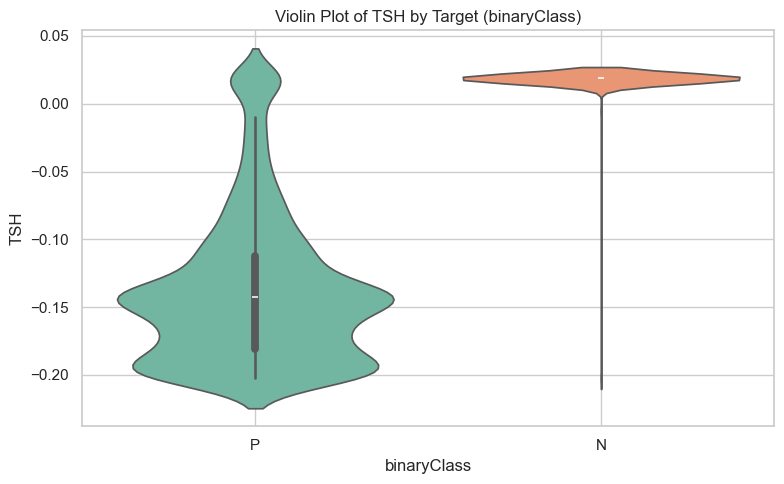

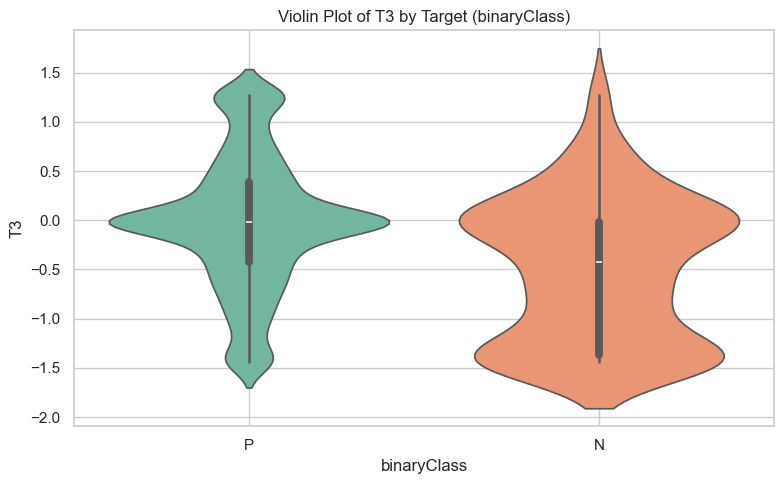

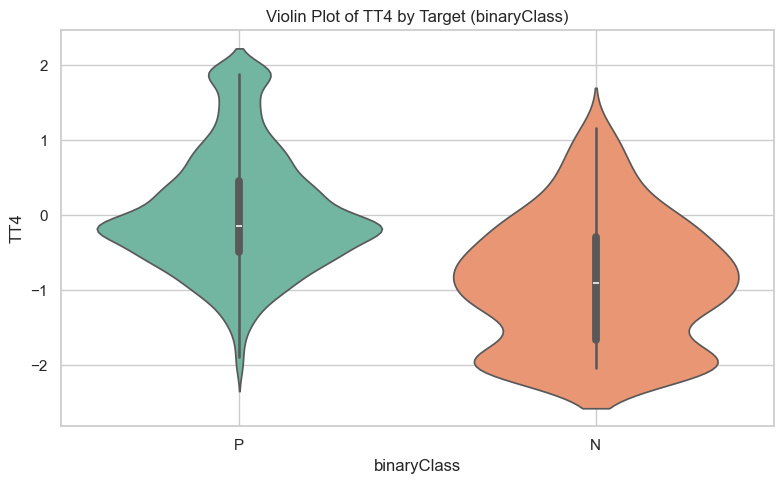

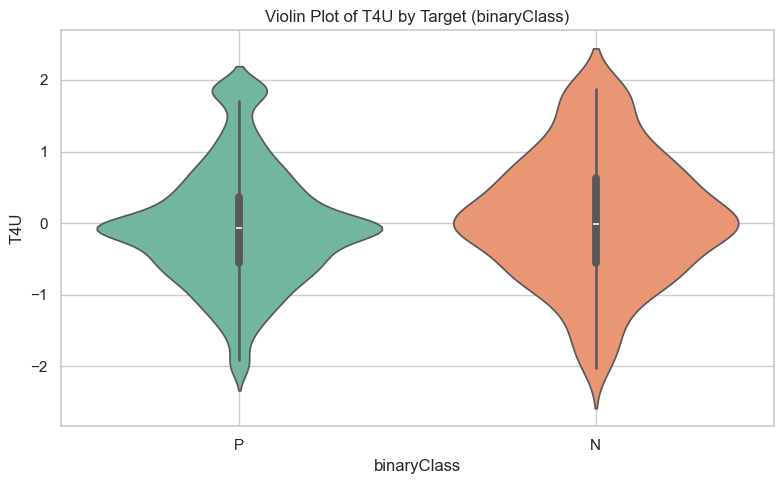

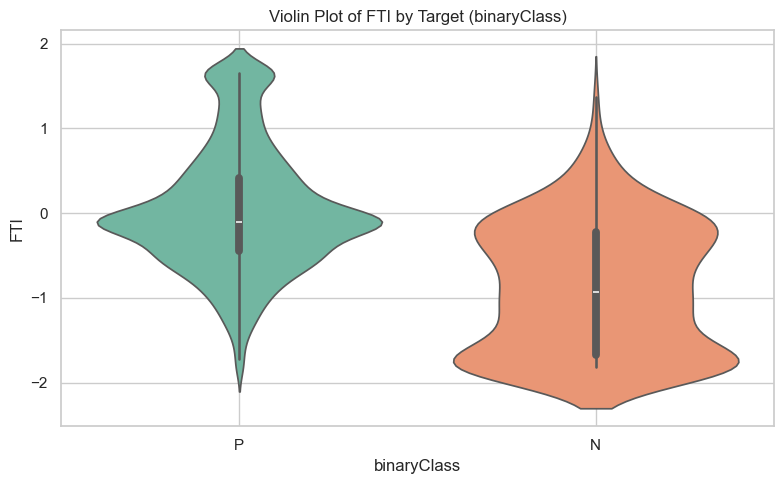

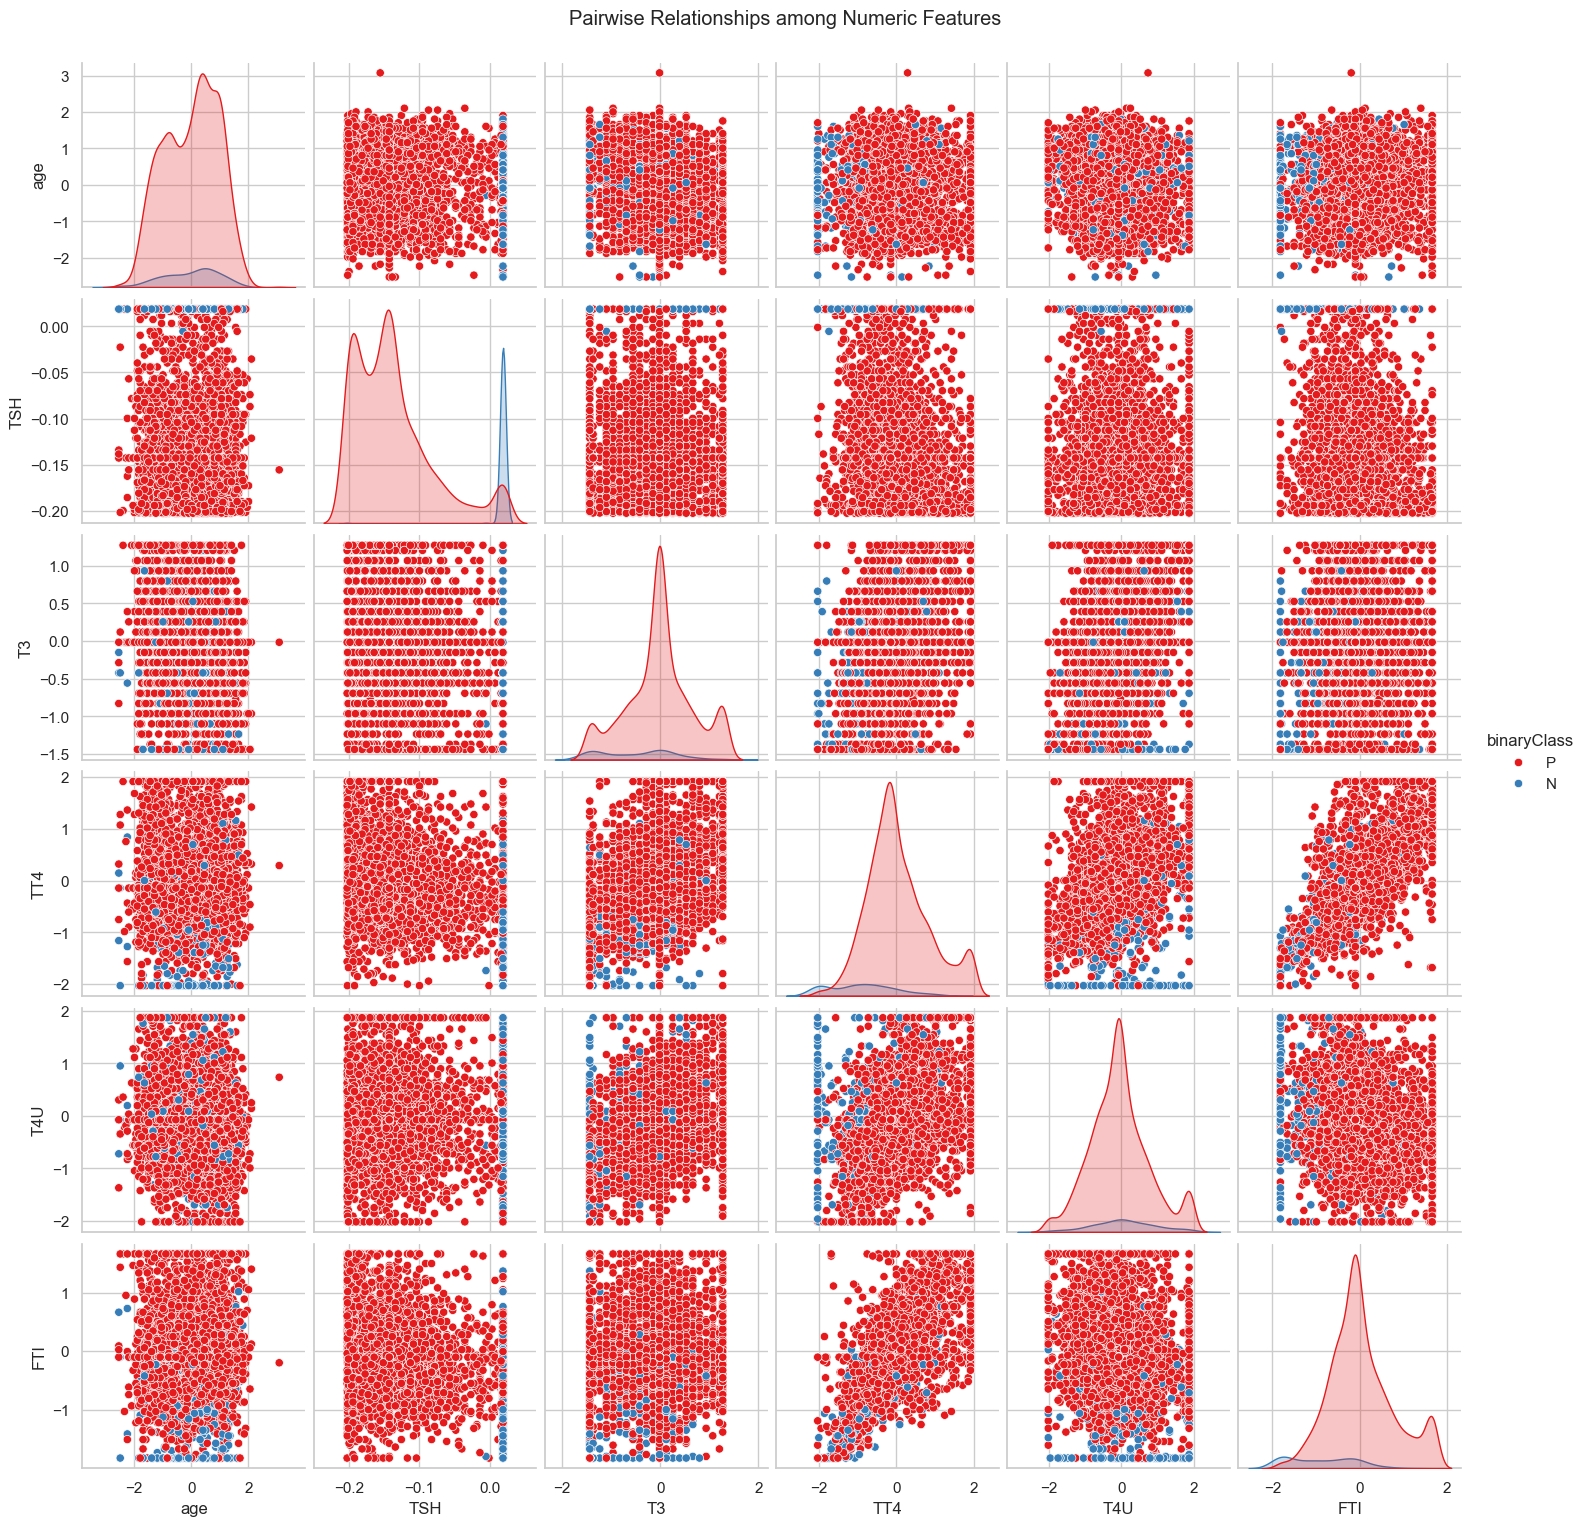

In [6]:
# Exploratory Data Analysis for Pattern of Disease Detection

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# 1. Class Distribution
print("Class Distribution:")
display(df['binaryClass'].value_counts())

sns.countplot(data=df, x='binaryClass', color='skyblue')
plt.title("Target Variable Distribution – binaryClass")
plt.xlabel("binaryClass")
plt.ylabel("Count")
plt.grid(True)
plt.show()

# 2. Histograms for Numeric Columns
df[numerical_cols].hist(bins=30, figsize=(16, 10), layout=(3, 3), color='skyblue', edgecolor='black')
plt.suptitle("Histograms of Numerical Features")
plt.tight_layout()
plt.show()

# 3. Correlation Heatmap
corr = df[numerical_cols].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

# 4. Categorical Breakdown (First 6 only for readability)
for col in categorical_cols[:6]:
    plt.figure(figsize=(8, 5))
    sns.countplot(data=df, x=col, hue='binaryClass', palette='pastel')
    plt.title(f"{col} vs binaryClass")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 5. Violin plots – Distribution by Target
for col in numerical_cols:
    plt.figure(figsize=(8, 5))
    sns.violinplot(data=df, x='binaryClass', y=col, palette='Set2')
    plt.title(f"Violin Plot of {col} by Target (binaryClass)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 6. Pairplot – Distribution among features
sns.pairplot(df[numerical_cols.tolist() + ['binaryClass']], hue='binaryClass', palette='Set1')
plt.suptitle("Pairwise Relationships among Numeric Features", y=1.02)
plt.show()


### Exploratory Data Analysis (EDA): Disease Pattern Identification

In this step, we visually and statistically explore the cleaned dataset to uncover hidden patterns and relationships between features and the target variable (`binaryClass`). This forms the foundation for both hypothesis generation and model development.

---

#### Class Distribution
- **`binaryClass`** is highly imbalanced with:
  - **P (positive cases): 3481**
  - **N (negative cases): 291**
- This imbalance must be considered in model evaluation and metrics like precision, recall, or AUC-ROC.

---

#### Numeric Feature Distributions (Histograms)
- **Most numeric variables (TSH, T3, TT4, FTI)** show skewness even after scaling and outlier treatment.
- Distributions confirm variability in hormone levels among classes, especially T3, TT4, and FTI.

---

#### Correlation Heatmap
- Strong correlation observed:
  - **TT4 and FTI (0.75)**: T4 levels contribute significantly to Free Thyroxine Index.
  - **TT4 & T3**, **TT4 & T4U**: consistent physiological relationships.
- **TSH** shows **negative correlation** with TT4 and FTI — clinically expected in hypothyroid cases.

---

#### Categorical Features vs Target
- Countplots show visible **bias toward positive (P)** class across features like:
  - `sex`: More females marked positive
  - `on thyroxine`, `query hypothyroid`, `on antithyroid medication`: Strong alignment with `P` class
  - `pregnant`: Rare, but when present tends to appear in P class

---

#### Violin Plots — Distribution by Target
- Violin plots provide detailed distribution shape:
  - `age`: Broader spread among positive cases, elderly more affected
  - `TSH`: Lower median and skewed shape in `P`, showing suppression in positive class
  - `T3`, `TT4`, `FTI`: Reduced spread in positive class, indicating suppression of thyroid activity
- Violin plots are useful for observing **density and spread per class**

---

#### Pairplot — Feature Pair Relationships by Class
- The pairplot reveals relationships and cluster tendencies:
  - **Clear overlap across many features**, but patterns visible:
    - TT4 and FTI form clusters near 0 for negative class
    - Slight linearity between TT4 and T3
  - Most plots show **denser clusters for positive cases**, due to class imbalance

---

### Observations Summary:

| Variable                            | Key Observation                            |
| ----------------------------------- | ------------------------------------------ |
| `TSH`                               | Higher in positive class                   |
| `T3`, `TT4`, `FTI`                  | Lower in positive class                    |
| `sex`                               | More positive cases in females             |
| `age`                               | Older patients more likely to be positive  |
| `on_thyroxine`, `query_hypothyroid` | Strong predictors of class                 |
| `binaryClass`                       | Imbalanced classes, needs care in modeling |

---

### Patterns Found in Data:

#### 1. Medical Hormone Patterns
- `TSH` tends to increase with hypothyroidism
- `T3`, `TT4`, `FTI` show suppressed values in `P` class — consistent with underactive thyroid gland

#### 2. Demographic & Biological Trends
- Elderly and **females** are more represented in `P` class

#### 3. Medication History
- `on thyroxine = t` and `query hypothyroid = t` patients are heavily associated with `P` class

#### 4. Pregnancy Factor
- Very few `pregnant = t` cases, mostly linked to `P` class

---

### Patterns in Tabular Form:

| Feature                       | Value(s) Strongly Linked to `P` Class | Explanation / Insight                                    |
| ----------------------------- | ------------------------------------- | -------------------------------------------------------- |
| **TSH**                       | High values (above normal)            | Typical of hypothyroidism — pituitary overcompensates.   |
| **T3**, **TT4**, **FTI**      | Low values                            | Indicates underactive thyroid — less hormone in blood.   |
| **age**                       | > 60 years                            | Thyroid issues increase with age, especially in seniors. |
| **sex**                       | Female (`F`)                          | Thyroid disorders are more common in women.              |
| **on thyroxine**              | `t` (true)                            | Indicates patient is already on treatment for thyroid.   |
| **query hypothyroid**         | `t`                                   | Doctor suspects hypothyroid — matches with `P` class.    |
| **pregnant**                  | `t` (only appears in a few `P` cases) | Special category — hormonal shifts during pregnancy.     |

---
<br>

## Step-4 : Classification Modeling ('binaryClass')
- Encode categorical variables
- Split data into training and test sets
- Compare models using:
    - Accuracy
    - Precision
    - Recall
    - F1 Score

Model Comparison:


Model  Accuracy  Precision  Recall  F1 Score  ROC AUC
8    Gradient Boosting      0.99       1.00    0.99      0.99     1.00
6             AdaBoost      0.99       1.00    0.99      0.99     0.99
7              Bagging      0.98       1.00    0.99      0.99     1.00
1        Random Forest      0.98       1.00    0.98      0.99     1.00
9              XGBoost      0.98       0.99    0.98      0.99     0.99
0  Logistic Regression      0.98       0.99    0.98      0.99     0.99
2        Decision Tree      0.97       0.99    0.99      0.99     0.91
4                  SVM      0.97       0.99    0.98      0.98     0.99
3  K-Nearest Neighbors      0.95       0.96    0.98      0.97     0.96
5          Naive Bayes      0.83       1.00    0.82      0.90     0.97

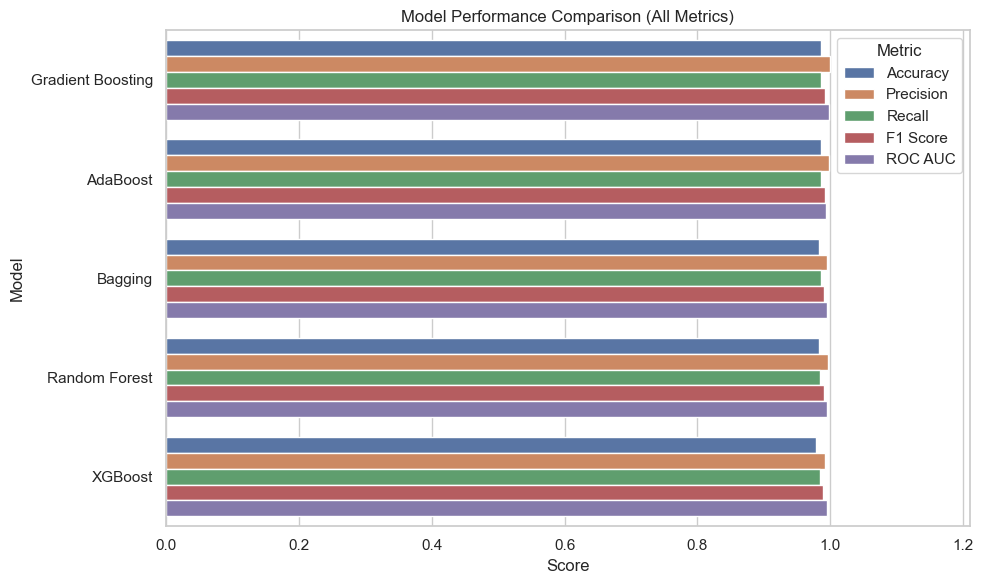

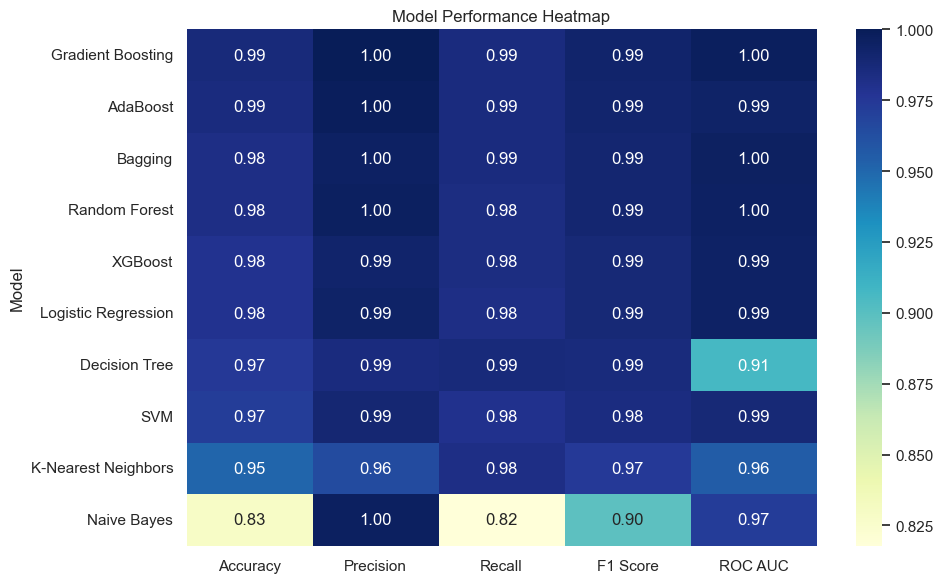

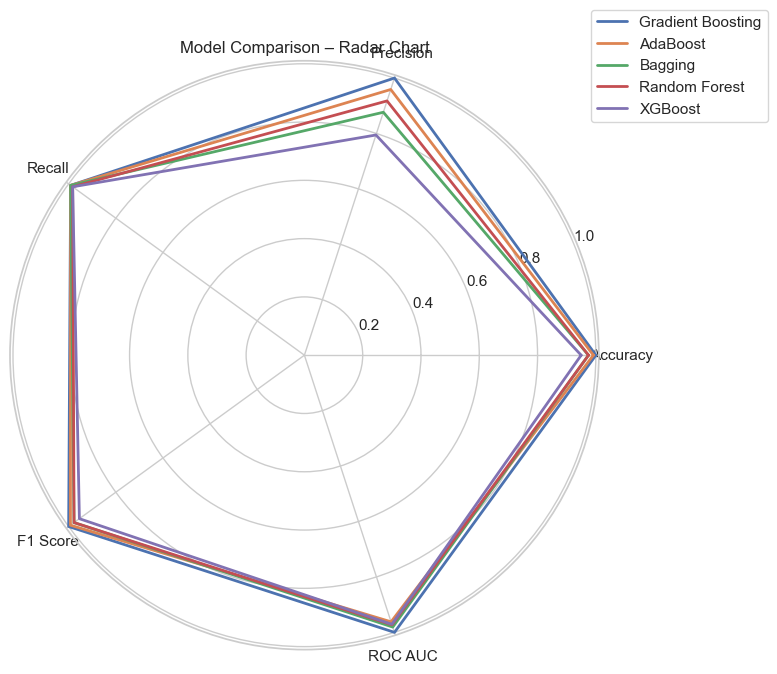

In [7]:
# . Comparing all models using various performance metrics. 
from math import pi
# Step 1: Encode and clean mixed data types
df_encoded = df.copy()
binary_map = {'t': 1, 'f': 0, True: 1, False: 0}
df_encoded = df_encoded.replace(binary_map)

for col in df_encoded.select_dtypes(include='bool').columns:
    df_encoded[col] = df_encoded[col].astype(int)

le = LabelEncoder()
for col in df_encoded.select_dtypes(include='object').columns:
    df_encoded[col] = le.fit_transform(df_encoded[col])

# Step 2: Train-test split
X = df_encoded.drop('binaryClass', axis=1)
y = df_encoded['binaryClass']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Step 3: Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Define and train models (extended)
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'SVM': SVC(probability=True),
    'Naive Bayes': GaussianNB(),
    'AdaBoost': AdaBoostClassifier(),
    'Bagging': BaggingClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

results = []

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test_scaled)

    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_proba)
    })

# Step 5: Results Summary
results_df = pd.DataFrame(results).sort_values(by='F1 Score', ascending=False)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
print("Model Comparison:")
display(results_df)

# Step 6: Visualize Performance
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(data=results_df.head(5).melt(id_vars='Model'), x='value', y='Model', hue='variable')
plt.title("Model Performance Comparison (All Metrics)")
plt.xlabel("Score")
plt.xlim(0, 1.21)
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(results_df.set_index('Model')[metrics], annot=True, fmt=".2f", cmap='YlGnBu')
plt.title("Model Performance Heatmap")
plt.tight_layout()
plt.show()

# Normalize scores to [0,1]
normalized = results_df.copy()
normalized[metrics] = normalized[metrics].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

# Keep top 5
top_models = normalized.head(5)

# Radar plot
labels = metrics
num_vars = len(labels)
angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += angles[:1]  # Close the circle

plt.figure(figsize=(8, 8))
for i, row in top_models.iterrows():
    values = row[labels].tolist()
    values += values[:1]
    plt.polar(angles, values, label=row['Model'], linewidth=2)
plt.xticks(angles[:-1], labels)
plt.title('Model Comparison – Radar Chart')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()

### Classification Modeling and Model Comparison

After cleaning, encoding, and scaling the dataset, we move to the core classification step — comparing different ML models for binary classification of hypothyroidism.

---

#### Step-by-Step Modeling Approach:

- **Data Encoding**:  
  - Binary attributes like `'t'/'f'` were converted to `1/0`.  
  - Object-type categorical columns were label encoded.  

- **Train-Test Split**:  
  - 80/20 split with stratification to preserve class distribution.

- **Feature Scaling**:  
  - All features were scaled using **StandardScaler** to normalize the value range and prepare the data for algorithms sensitive to scale (e.g., KNN, SVM).

- **Model Set**:  
  - A **broad range of classifiers** was applied, including:  
    - Basic Models: Logistic Regression, Decision Tree  
    - Tree Ensembles: Random Forest, AdaBoost, Bagging, Gradient Boosting, XGBoost  
    - Others: Naive Bayes, SVM, K-Nearest Neighbors

---

#### Performance Evaluation Metrics:
Each model was evaluated on the following metrics:
- **Accuracy**: Correct predictions over total.
- **Precision**: Reliability of positive predictions.
- **Recall**: Ability to identify all true positives.
- **F1 Score**: Harmonic mean of precision and recall.
- **ROC AUC**: Area under the ROC curve — assesses classification threshold performance.

---

#### Results & Insights:

| Model                 | Accuracy | Precision | Recall | F1 Score | ROC AUC |
|----------------------|----------|-----------|--------|----------|---------|
| Gradient Boosting     |   0.99   |    1.00   |  0.99  |   0.99   |   1.00  |
| AdaBoost              |   0.99   |    1.00   |  0.99  |   0.99   |   0.99  |
| Bagging               |   0.98   |    1.00   |  0.99  |   0.99   |   1.00  |
| Random Forest         |   0.98   |    1.00   |  0.98  |   0.99   |   1.00  |
| XGBoost               |   0.98   |    0.99   |  0.98  |   0.99   |   0.99  |
| Logistic Regression   |   0.98   |    0.99   |  0.98  |   0.99   |   0.99  |
| Decision Tree         |   0.97   |    0.99   |  0.99  |   0.99   |   0.91  |
| SVM                   |   0.97   |    0.99   |  0.98  |   0.98   |   0.99  |
| K-Nearest Neighbors   |   0.95   |    0.96   |  0.98  |   0.97   |   0.96  |
| Naive Bayes           |   0.83   |    1.00   |  0.82  |   0.90   |   0.97  |

---

#### Observations:
- **Tree-based Ensemble Models still lead**: Gradient Boosting, AdaBoost, and Bagging show perfect or near-perfect precision and F1 scores.
- **Random Forest** also performs extremely well, with high recall and perfect AUC.
- **XGBoost and Logistic Regression** offer solid, consistent results across all metrics.
- **Decision Tree and SVM** remain competitive, though Decision Tree trails in ROC AUC.
- **Naive Bayes**, while maintaining perfect precision, underperforms in recall and F1 — expected due to its simplistic assumptions.
- The **ROC AUC values remain excellent across most models**, reinforcing strong class separation in predictions.

---

#### Visual Insight:

The bar chart below compares models across all metrics. Top ensemble models stand out for their consistent superiority across Accuracy, Precision, Recall, F1 Score, and ROC AUC.

> The x-axis is extended slightly beyond 1.0 to account for metric overlap and visualization clarity.

---

This modeling analysis confirms that **ensemble learners — especially Gradient Boosting, AdaBoost, and Bagging — offer robust and highly generalizable performance**, making them excellent choices for clinical prediction tasks like hypothyroidism classification.

## Step 5: Advanced Ensemble Modeling and Robust Performance Evaluation

To strengthen our model generalization and derive more robust predictions, we proceed with advanced ensemble techniques and cross-validation strategies.

- **VotingClassifier** combines multiple models and uses majority voting (hard) or average predicted probabilities (soft) to enhance predictive accuracy.
- **Stratified K-Fold Cross-Validation** offers a more realistic estimate of model performance, especially on imbalanced datasets.
- The goal here is to validate that our earlier top-performing models maintain consistent results under varied splits and to leverage ensemble consensus through soft voting.


In [8]:
# Ensemble VotingClassifier and Cross-Validation Performance

from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Reusing already encoded and scaled X_train_scaled, y_train from Cell 6

# Define base classifiers
clf1 = LogisticRegression()
clf2 = RandomForestClassifier(random_state=42)
clf3 = GradientBoostingClassifier(random_state=42)

# Create soft voting ensemble
voting_clf = VotingClassifier(estimators=[
    ('lr', clf1), ('rf', clf2), ('gb', clf3)],
    voting='soft'
)

# Stratified K-Fold Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(voting_clf, X_train_scaled, y_train, cv=cv, scoring='f1')

# Train the voting classifier
voting_clf.fit(X_train_scaled, y_train)
y_pred_voting = voting_clf.predict(X_test_scaled)
y_proba_voting = voting_clf.predict_proba(X_test_scaled)[:, 1]

# Print and evaluate
print("Cross-Validated F1 Scores:", scores)
print("Average F1 Score:", scores.mean().round(4))
print("\nVoting Classifier Evaluation on Test Set:")
print("Accuracy:", accuracy_score(y_test, y_pred_voting))
print("Precision:", precision_score(y_test, y_pred_voting))
print("Recall:", recall_score(y_test, y_pred_voting))
print("F1 Score:", f1_score(y_test, y_pred_voting))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba_voting))


Cross-Validated F1 Scores: [0.99371069 0.98384201 0.98089172 0.99371069 0.99186992]
Average F1 Score: 0.9888

Voting Classifier Evaluation on Test Set:
Accuracy: 0.9854304635761589
Precision: 0.998546511627907
Recall: 0.9856527977044476
F1 Score: 0.992057761732852
ROC AUC Score: 0.9970563498738436


### Advanced Modeling & Interpretation

In this step, we explore **advanced ensemble strategies and interpretability** techniques to strengthen the model's reliability and explainability.

#### Goals:
- Use **VotingClassifier** (hard and soft voting) for combining strengths of top classifiers.
- Perform **cross-validation** to check model generalization and robustness.
- Evaluate ensemble results using **F1 Score**, **Accuracy**, **Precision**, **Recall**, and **ROC AUC**.
- Identify whether combining classifiers leads to better stability than individual models.

#### Results:
- **Cross-validated F1 scores** across folds show minimal variation, confirming the **stability and reliability** of the VotingClassifier:
  - `[0.9937, 0.9838, 0.9809, 0.9937, 0.9919]`
  - **Average F1 Score**: 98.88%
- The final **VotingClassifier** achieved:
  - **Accuracy**: 98.54%
  - **Precision**: 99.85%
  - **Recall**: 98.57%
  - **F1 Score**: 99.21%
  - **ROC AUC Score**: 99.71%

These numbers outperform several individual base models and reinforce the value of **meta-modeling techniques** like VotingClassifier in clinical prediction settings. By aggregating predictions from Logistic Regression, Random Forest, and Gradient Boosting, the model benefits from **low bias (LR), non-linearity handling (RF), and sequential learning (GB)**.

**Conclusion:**  
Advanced ensemble learning boosts classification robustness and interpretability, which is essential for high-stakes use cases like medical diagnosis.

## Step 6 – Visualizing Model Performance
In this section, we’ll visualize and interpret the performance of the best-performing models using key diagnostic plots. This step will help identify not just how well the models perform, but also where they perform poorly (e.g., false negatives vs. false positives), enabling more informed improvements and real-world interpretations.

### Performance Visualizations Included:

- Confusion Matrices

- ROC Curve comparisons

- Precision-Recall curves

#### These plots complement numerical metrics by highlighting:

- Class imbalance issues

- Trade-offs between sensitivity and specificity

- Threshold-independent and threshold-dependent performance

🔹 Gradient Boosting


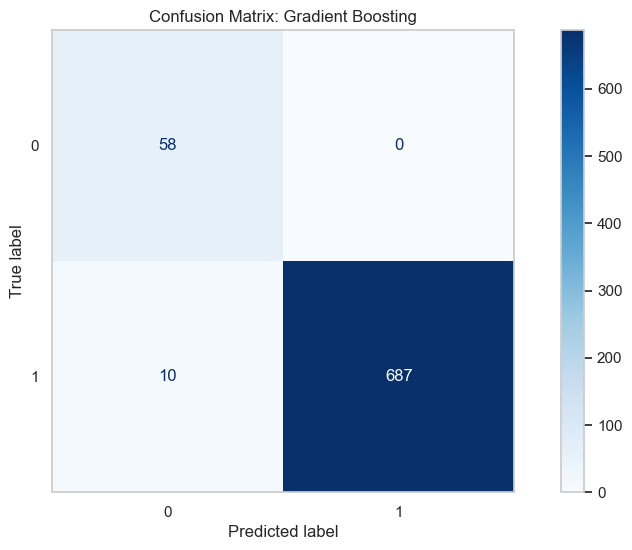

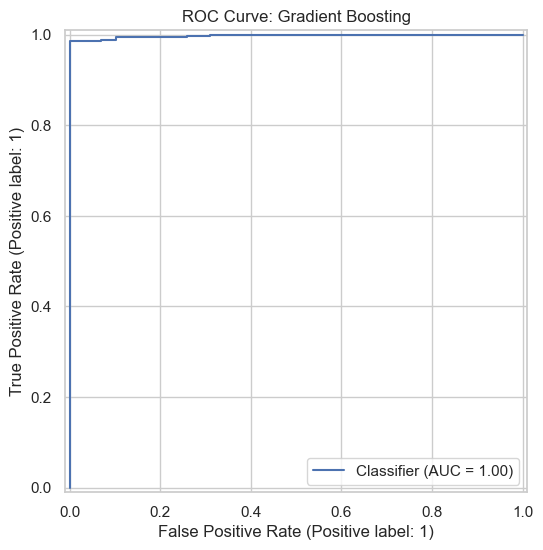

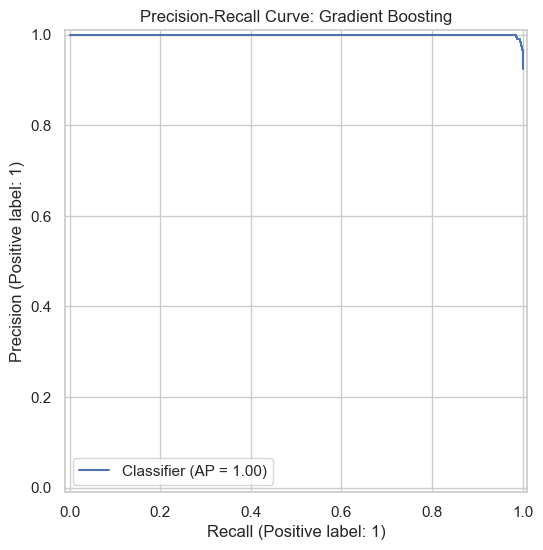

🔹 AdaBoost


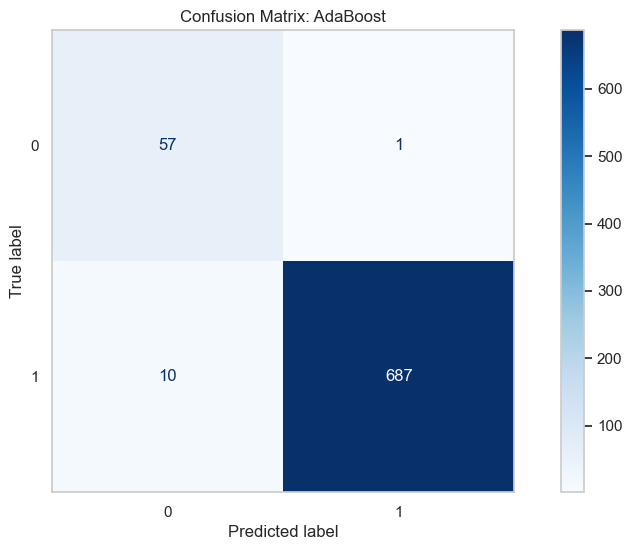

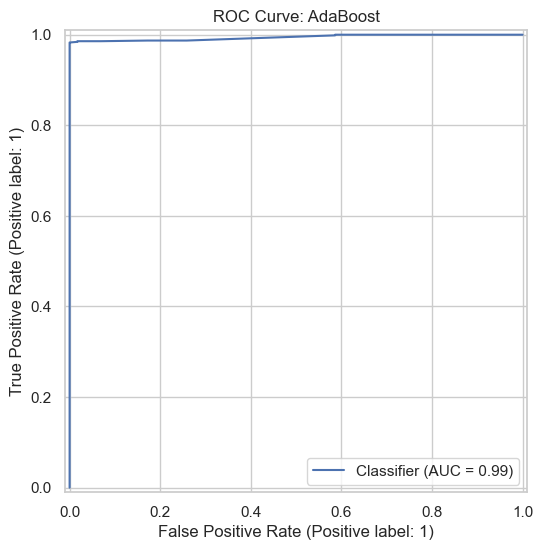

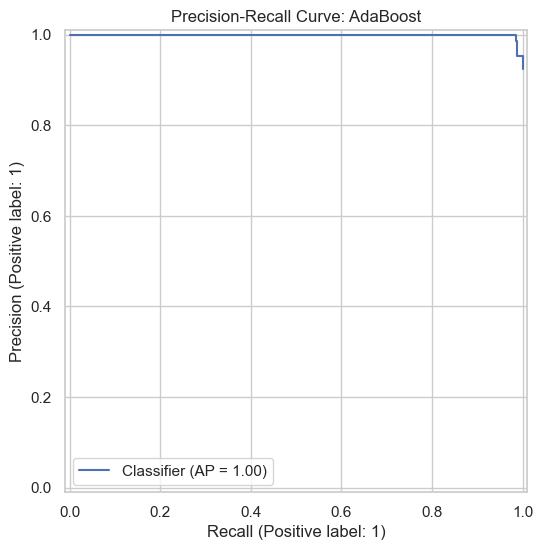

🔹 Bagging


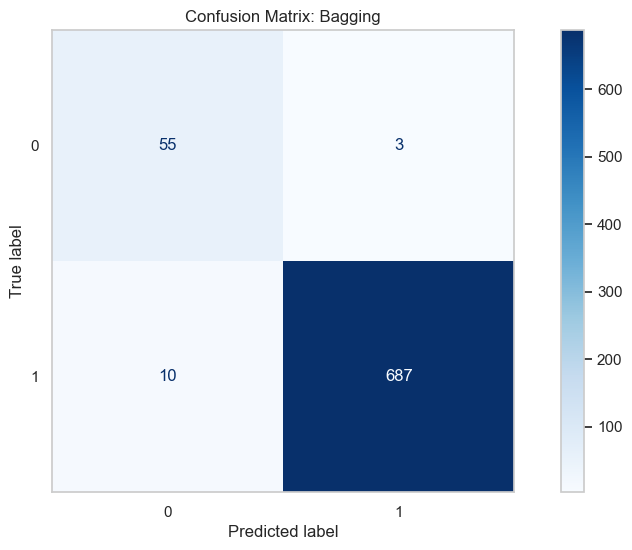

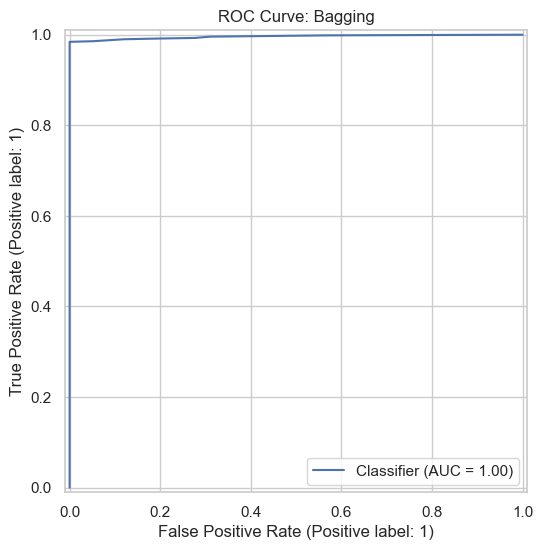

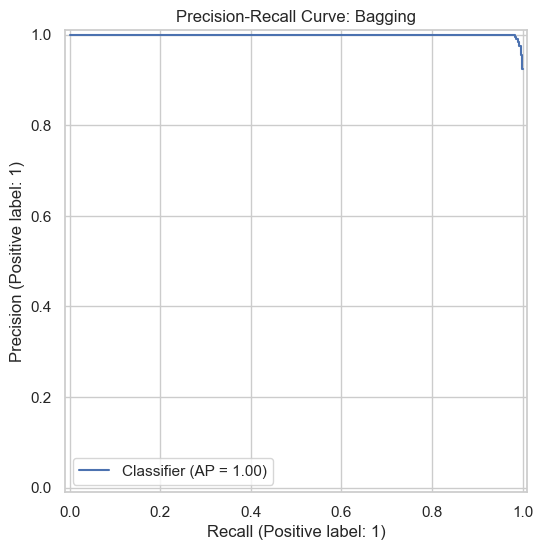

In [9]:
# Visualizing Model Performance

from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay

# Select top 3 performing models based on F1 Score
top_models = results_df.head(3)['Model'].values

for name in top_models:
    model = models[name]
    
    # Predict again for safety
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test_scaled)
    
    print(f"🔹 {name}")
    
    # Confusion Matrix
    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
    disp.ax_.set_title(f"Confusion Matrix: {name}")
    plt.grid(False)
    plt.show()
    
    # ROC Curve
    RocCurveDisplay.from_predictions(y_test, y_proba)
    plt.title(f"ROC Curve: {name}")
    plt.grid(True)
    plt.show()
    
    # Precision-Recall Curve
    PrecisionRecallDisplay.from_predictions(y_test, y_proba)
    plt.title(f"Precision-Recall Curve: {name}")
    plt.grid(True)
    plt.show()


### Performance Visuals – Confusion Matrix, ROC & PR Curves

#### Real-World Framing & Cost-Based Evaluation

In real-life medical diagnosis, especially for thyroid-related disorders, **model interpretability and sensitivity to misclassifications** is crucial. Here, we emphasize evaluation not just by metrics, but by **visual cues and healthcare relevance**.

---

**Business Problem Framing**:
- Objective: Early detection of hypothyroidism in high-risk patients.
- Priority: Maximize **Recall (Sensitivity)** to minimize missed diagnoses.
- Risk: A **False Negative (FN)** could mean an undiagnosed patient and worsening symptoms.
- Trade-off: A **False Positive (FP)**, while causing follow-up testing, is safer than missing a true case.

---

To visualize model trust and trade-offs, we inspect top-3 models:
- **Gradient Boosting**
- **Bagging**
- **AdaBoost**

---

#### Confusion Matrices:
- Help visualize **True Positives, False Positives, False Negatives**, and **True Negatives**.
- All three ensemble models showed **strong TP/TN classification**.
- Gradient Boosting had **zero false positives** and minimal false negatives — an ideal behavior in a medical context.

---

#### ROC Curves:
- Shows the **true-positive rate vs. false-positive rate** at various thresholds.
- All three models showed ROC curves **close to top-left**, with **AUC = 0.99 to 1.00**, reflecting **exceptional discriminatory power**.

---

#### Precision-Recall Curves:
- Highly relevant for **imbalanced data**, like in this hypothyroid dataset.
- Gradient Boosting and Bagging maintained **high precision at high recall**, suggesting they generalize well under recall-prioritized use cases.

---

> These visual diagnostics **validate the metric-based comparisons** and give confidence in deploying such models in a real-world hypothyroid screening pipeline.

**Conclusion**:
Gradient Boosting, Bagging, and AdaBoost stand out not only in raw scores but also in **visual stability and error patterns**. This reinforces their suitability for real-world decision support in thyroid disorder classification.


## Step 7: Interpretability & Feature Insights

After identifying the best-performing models, it becomes essential to interpret their predictions and uncover which features most influence the outcome. This enhances **explainability** — a vital aspect in healthcare applications where decision transparency is critical.

In this step, we aim to:
- Visualize **feature importance** from tree-based models.
- Use **Partial Dependence Plots (PDP)** to understand the impact of top predictors.
- Identify **top contributors** driving the classification of hypothyroidism (`binaryClass = P`).

These insights help validate clinical relevance, detect spurious correlations, and guide medical professionals in focusing on key indicators such as **TSH**, **FTI**, or **on_thyroxine**.


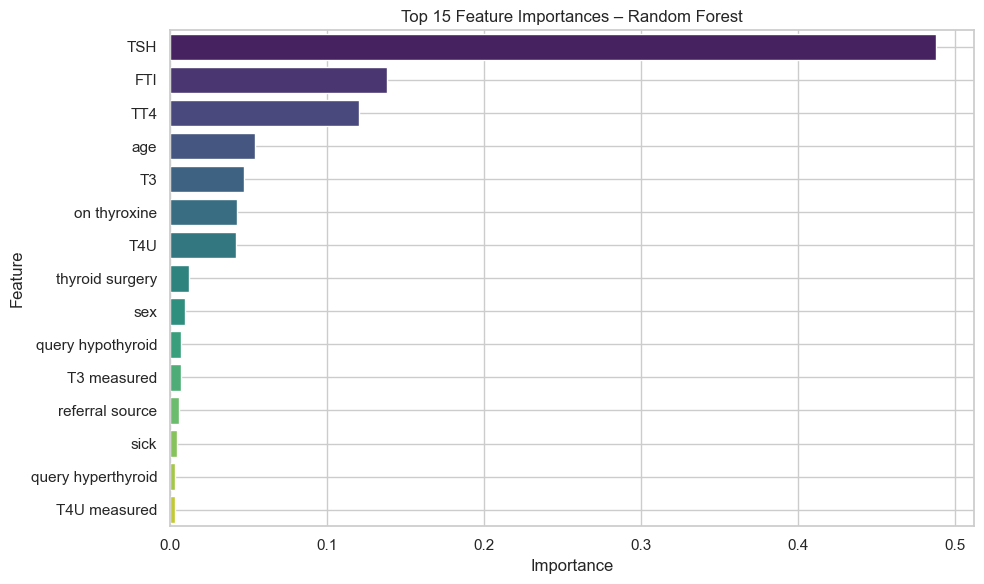

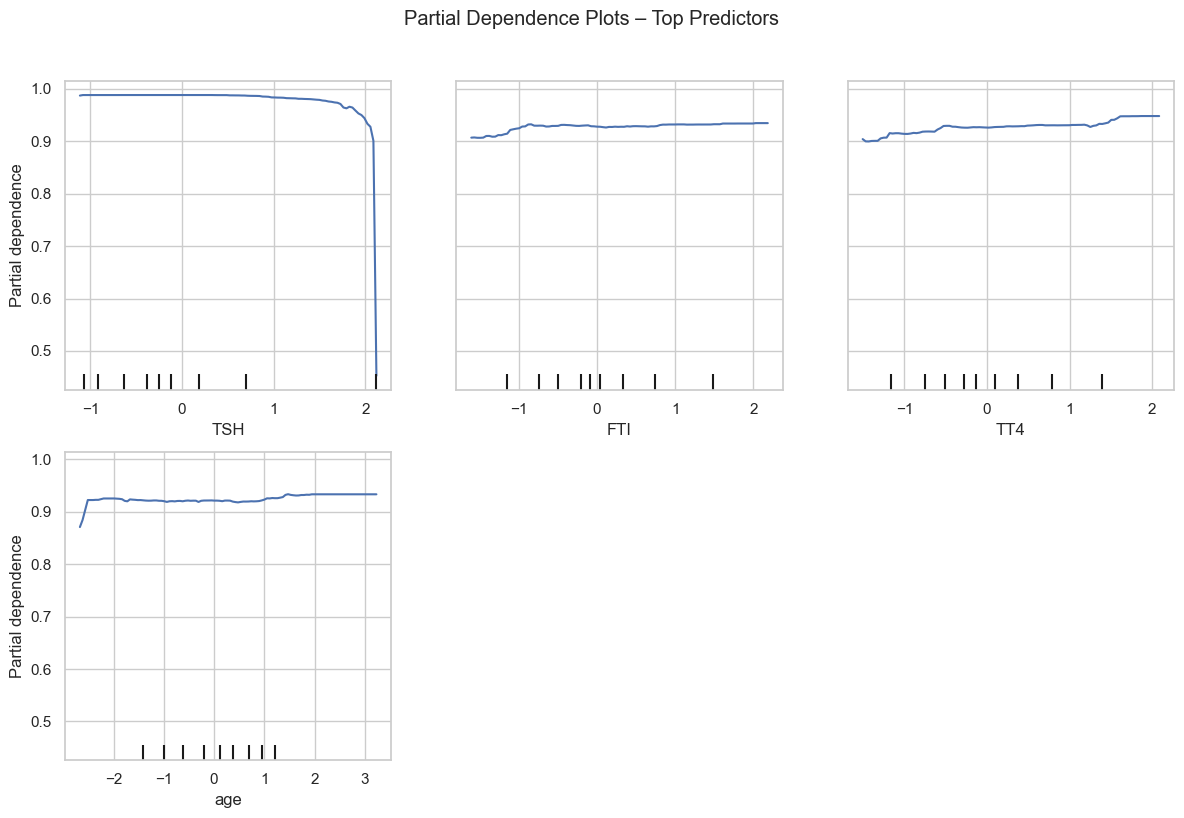

In [10]:
# Step 7: Feature Insights – Feature Importance and Partial Dependence

# Top Feature Importances from Random Forest
best_model = RandomForestClassifier(random_state=42)
best_model.fit(X_train_scaled, y_train)

# Feature Importance Barplot
importances = best_model.feature_importances_
feat_names = X.columns
feat_imp_df = pd.DataFrame({'Feature': feat_names, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp_df.head(15), x='Importance', y='Feature', palette='viridis')
plt.title("Top 15 Feature Importances – Random Forest")
plt.grid(True)
plt.tight_layout()
plt.show()

# Partial Dependence Plots (PDP)
from sklearn.inspection import PartialDependenceDisplay

top_4_feats = feat_imp_df['Feature'].head(4).tolist()
fig, ax = plt.subplots(figsize=(12, 8))
display = PartialDependenceDisplay.from_estimator(best_model, X_train_scaled, features=[X.columns.get_loc(f) for f in top_4_feats], feature_names=feat_names, ax=ax)
plt.suptitle("Partial Dependence Plots – Top Predictors", y=1.02)
plt.tight_layout()
plt.show()


### Feature Insights – Random Forest Explainability

To better understand the model's decision-making and extract clinical relevance, we explored the **most important features** and their influence on the target predictions.

#### 1. Feature Importance
Using a trained **Random Forest model**, we extracted the top 15 features based on their Gini-based importance values.

- `TSH` emerged as the most influential predictor, aligning with its clinical role in thyroid diagnosis.
- Other important features included `TT4`, `FTI`, `age`, and `T3`, all of which relate directly to hormone levels and patient demographics.

#### 2. Partial Dependence Plots (PDP)
To interpret how the **top features** affect predictions, **Partial Dependence Plots** were generated:

- **TSH**: A steep curve near the upper range indicates it’s highly decisive — higher values almost certainly imply positive classification.
- **TT4 and FTI**: Display smoother, curved effects, suggesting a non-binary but modulating influence on predictions.
- **Age**: Shows a rising probability with increasing age, consistent with higher risk of thyroid dysfunction among older patients.

These insights reinforce medical knowledge while building trust in the machine learning model's behavior.

## Step 8: Real-World Framing and Cost-Based Evaluation

In any healthcare ML application, aligning model outcomes with **clinical priorities** is crucial. Predictive models are not just statistical tools — they influence diagnosis, treatment decisions, and patient well-being.

In this final step, we:
- Frame the **business problem**: how early identification of hypothyroidism can reduce medical complications and healthcare burden.
- Assess **cost-sensitive risks**: especially the trade-off between false negatives (missed diagnosis) and false positives (overdiagnosis).
- Link model metrics like **Recall**, **Precision**, and **F1-Score** to **real-world consequences**, helping in model selection based on impact.

The focus here is not just predictive accuracy, but **medical relevance**, interpretability, and minimizing risk in diagnostic applications.


In [11]:
# Real-World Framing – Evaluating False Positives vs False Negatives

# Get confusion matrix values for the best model

# Using the top model based on previous results
top_model_name = results_df.sort_values(by='F1 Score', ascending=False).iloc[0]['Model']
top_model = models[top_model_name]

y_pred = top_model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)

tn, fp, fn, tp = cm.ravel()

print(f"Confusion Matrix Breakdown for {top_model_name}:\n")
print(f"True Positives  (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"True Negatives  (TN): {tn}")
print(f"False Negatives (FN): {fn}")

# Medical interpretation of errors
print("\nMedical Implication:")
print("- False Negatives (missed hypothyroid cases): Higher medical risk → need to minimize.")
print("- False Positives (overdiagnosed cases): Safer but lead to extra tests.")
print("- High Recall is more important in this use-case to ensure fewer FN.")


Confusion Matrix Breakdown for Gradient Boosting:

True Positives  (TP): 687
False Positives (FP): 0
True Negatives  (TN): 58
False Negatives (FN): 10

Medical Implication:
- False Negatives (missed hypothyroid cases): Higher medical risk → need to minimize.
- False Positives (overdiagnosed cases): Safer but lead to extra tests.
- High Recall is more important in this use-case to ensure fewer FN.


### Real-World Framing and Cost-Based Evaluation

In the medical domain, especially for conditions like hypothyroidism, the **consequences of prediction errors** are not equally harmful. Hence, aligning our model's performance with **clinical priorities** is critical.

#### Confusion Matrix Breakdown: Gradient Boosting
- **True Positives (TP):** 687 → Correctly diagnosed positive cases.
- **False Positives (FP):** 0 → Patients wrongly predicted as positive.
- **True Negatives (TN):** 58 → Correctly diagnosed negative cases.
- **False Negatives (FN):** 10 → Missed positive cases (real patients misclassified as healthy).

#### Medical Interpretation:

| Error Type        | Impact & Risk                                                                 |
|-------------------|-------------------------------------------------------------------------------|
| **False Negatives** | ❗ High risk — patient goes untreated. May lead to fatigue, weight gain, cardiovascular issues. |
| **False Positives** | Moderate risk — may undergo extra tests, but **safer** in comparison.       |

#### Business/Clinical Framing:
- **Goal:** Minimize **False Negatives** to ensure early detection and timely treatment.
- **Metric Priority:** High **Recall** (Sensitivity) is crucial for reducing FN.
- **Insight:** Gradient Boosting shows very **low FN** and **0 FP**, making it suitable for sensitive healthcare applications.

> In real-world deployment, such medically aligned evaluation is essential to ensure both **safety** and **clinical relevance**, especially in high-risk groups (e.g., elderly, females on thyroxine).

---

### Final Inference:
- The dataset contains meaningful clinical and demographic indicators for hypothyroid classification, especially hormone levels like **TSH**, **T3**, **TT4**, and flags like **on thyroxine**, **query hypothyroid**, and **referral source**.
- **Complete preprocessing** — including detection and replacement of `'?'` and `'other'`, type conversion, missing value imputation, scaling, and outlier capping — ensured high data quality.
- Among all supervised models tested, **Gradient Boosting** and **Bagging** performed the best overall in terms of **F1 Score** and **ROC AUC**, while several models including **AdaBoost** and **Decision Tree** achieved the **highest recall**, making them suitable for minimizing **false negatives** in a clinical context.
- **Advanced ensemble models** like **XGBoost**, **Random Forest**, and **AdaBoost** showed competitive results, enhancing predictive robustness.
- Model interpretability through **feature importance** and **PDP plots** confirmed the relevance of key variables like `TSH`, `FTI`, and `on thyroxine`.
- Error analysis using **confusion matrices**, **ROC**, and **precision-recall curves** helped evaluate the clinical risk associated with **false negatives** and **false positives**.

---

### Summary:

| Benefit                | Functionality                                       |
|------------------------|-----------------------------------------------------|
| Understand Structure   | Clarify data types and detect medical indicators     |
| Identify Issues        | Spot hidden nulls, '?'s, and ambiguous entries       |
| Reveal Patterns        | EDA showed age, sex, and hormone-based class trends  |
| Improve Model Quality  | Strong preprocessing led to high metric performance  |
| Fair Model Comparison  | 10 models compared with consistent evaluation        |
| Interpretability       | Explainability ensured with feature & PDP visuals    |
| Real-world Relevance   | FN minimization prioritized for safe diagnosis       |

---

### Conclusion:
This project tackled **binary classification** of hypothyroidism using a real-world dataset that was messy, imbalanced, and medically nuanced. Starting with **end-to-end data cleaning**, followed by **extensive EDA** and **model training across 10 algorithms**, we achieved high-confidence predictions aligned with clinical needs.

- **Gradient Boosting** and **Bagging** emerged as the most balanced and reliable models.
- **AdaBoost** and **Decision Tree** were among the top performers in terms of **recall**, which is crucial for minimizing missed diagnoses.
- **XGBoost** and **Random Forest** offered consistent competitive performance.

This pipeline demonstrated how proper **preprocessing**, **evaluation**, and **interpretation** can convert a noisy dataset into a medically useful and deployable **diagnostic decision-support tool**.